# Randomized Singular Value Decomposition
## Introduction:
The goal of this project was to develop a randomized procedure for singular value decomposition in a way that is faster for massive scale matrix.

The developed algorithms are based on the following article: https://arxiv.org/abs/0909.4061, using numpy tools.

A secondary goal was to compare the direct implementation of the svd from numpy, with the randomized version proposed by this article, both in terms of precision and performance (time).

In [1]:
import numpy as np
import math
import sklearn
from sklearn.datasets import make_low_rank_matrix
import matplotlib.pyplot as plt

In [2]:
class RSVD:
    p = 5
    mu, sigma = 0, 1 
    def __init__(self, A, epsilon, rank=None):
        self.A = A
        self.epsilon = epsilon
        self.rank = rank
        self.n = self.A.shape[1]
        self.W = None
        self.Q = None
        if self.rank is not None:
            if rank + 5 > self.n:
                raise ValueError("Rank too high (rank + 5 must be inferior or equal to n)")
        
        
    def compute_orthogonal_base_Q_rank(self, mode):
        '''
        This method modifies the Q parameter of an object RSVD, with fixed rank.
        The added parameter 'mode' here was added to be able to choose between two methods of creation of the matrix 'Y'.
        
                Parameters:
                    mode (int): 0 if randomized gaussian distribution test matrix
                                1 if random uniform sampling of the columns of A
        '''
        l = self.rank + self.p
        if mode == 0:
            self.W = np.random.normal(self.mu, self.sigma, (self.n, l))
            Y = self.A @ self.W
        else:
            Y = self.A[:,np.random.randint(0,self.n-1,size=l)]
        self.Q, _ = np.linalg.qr(Y, mode='reduced')
        
    def compute_orthogonal_base_Q_rank_with_factorisation(self, mode, it=2):
        '''
        This method modifies the Q parameter of an object RSVD, with fixed rank.
        The added parameter 'it' here was added to choose the number of iteration of the additionnal factorisation.
        
                Parameters:
                    mode (int): 0 if randomized gaussian distribution test matrix
                                1 if random uniform sampling of the columns of A
                    it (int): n number of factorisation iterations
        '''
        l = self.rank + self.p
        if mode == 0:
            self.W = np.random.normal(self.mu, self.sigma, (self.n, l))
            Y = self.A @ self.W
        else:
            Y = self.A[:,np.random.randint(0,self.n-1,size=l)]
        Q, _ = np.linalg.qr(Y, mode='reduced')
        for _ in range(it):
            Y = A.T @ Q
            Q, _ = np.linalg.qr(Y, mode='reduced')
            Y = A @ Q
            Q, _ = np.linalg.qr(Y, mode='reduced')
        self.Q = Q
        
    def compute_orthogonal_base_Q_epsilon(self):
        '''
        This method modifies the Q parameter of an object RSVD, with fixed precision.
        '''
        r = 10
        W = np.random.normal(self.mu, self.sigma, (self.n, r))
        Y = A @ W
        m = self.A.shape[0]
        Q = np.zeros((m, 1))
        j = 0
        while np.linalg.norm(Y[:, j+1:], axis=1).max() > self.epsilon/(10*(2/math.pi)**0.5):
            j += 1
            I = np.identity(m)
            Y[:, j] = (I - Q @ Q.T) @ Y[:, j]
            q = Y[:, j] / np.linalg.norm(Y[:, j])
            Q = np.c_[Q, q]
            wr = np.random.normal(self.mu, self.sigma, self.n)
            Y = np.c_[Y, ((I - Q @ Q.T) @ (A @ wr))]
            Y[:, j+1:j+r] -= np.tile(q, (r-1, 1)).T * np.dot(q, Y[:, j+1:j+r])
        self.Q = Q[:, 1:]
        
    def compute_orthogonal_base_Q_epsilon_with_factorisation(self, it=2):
        '''
        This method modifies the Q parameter of an object RSVD, with fixed precision.
        The added parameter 'it' here was added to choose the number of iteration of the additionnal factorisation.
        
                Parameters:
                    it (int): n number of factorisation iterations
        '''
        r = 10
        W = np.random.normal(self.mu, self.sigma, (self.n, r))
        Y = A @ W
        Qbis, _ = np.linalg.qr(Y, mode='reduced')
        for _ in range(it):
            Y = A.T @ Qbis
            Qbis, _ = np.linalg.qr(Y, mode='reduced')
            Y = A @ Qbis
            Qbis, _ = np.linalg.qr(Y, mode='reduced')
        m = self.A.shape[0]
        Q = np.zeros((m, 1))
        j = 0
        while np.linalg.norm(Y[:, j+1:], axis=1).max() > self.epsilon/(10*(2/math.pi)**0.5):
            j += 1
            I = np.identity(m)
            Y[:, j] = (I - Q @ Q.T) @ Y[:, j]
            q = Y[:, j] / np.linalg.norm(Y[:, j])
            Q = np.c_[Q, q]
            wr = np.random.normal(self.mu, self.sigma, self.n)
            Y = np.c_[Y, ((I - Q @ Q.T) @ (A @ wr))]
            Y[:, j+1:j+r] -= np.tile(q, (r-1, 1)).T * np.dot(q, Y[:, j+1:j+r])
        self.Q = Q[:, 1:]
            
        
    def compute_svd(self):
        '''
        This method computes rsvd and returns the singular vectors and values.
        
                Returns:
                    U (numpy.array):  left-singular vectors
                    S (numpy.array):  singular values
                    VT (numpy.array): right-singular vectors
        '''
        B = self.Q.T @ self.A
        U_tilde, S, VT = np.linalg.svd(B,full_matrices=0)
        U = self.Q @ U_tilde
        return U, S, VT
    
    def compute_svd_truncation(self):
        '''
        This method computes rsvd and returns only the r (rank) singular vectors and values.
        
                Returns:
                    U (numpy.array):  left-singular vectors
                    S (numpy.array):  singular values
                    VT (numpy.array): right-singular vectors
        '''
        B = self.Q.T @ self.A
        U_tilde, S, VT = np.linalg.svd(B,full_matrices=0)
        U = self.Q @ U_tilde
        if self.rank is None:
            return U, S, VT
        else:
            return U[:,:self.rank], S[:self.rank], VT[:self.rank,:]

## Implementation examples and plots of analysis
The following section includes examples of utilisation of the previous class RSDV, and plots comparing results obtained with the direct and randomized approach.
### Definitions:

In [3]:
A = np.random.randint(0, 100, size=(100, 100))
print(np.linalg.matrix_rank(A,0))
U, S, VT = np.linalg.svd(A,full_matrices=0)
#rsvd = RSVD(A, 1e-9)
rsvd = RSVD(A, None, rank=80)
#rsvd.compute_orthogonal_base_Q_rank(0)
rsvd.compute_orthogonal_base_Q_rank_with_factorisation(0)
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()

100


The value 'np.linalg.matrix_rank(A,0)' is representing the rank of the matrix A.

In [4]:
S_tilde = np.diag(s_tilde)
A_tilde = U_tilde @ S_tilde @ VT_tilde
print(np.linalg.norm(A-A_tilde))

227.3489250452781


The value 'np.linalg.norm(A-A_tilde)' is representing the error of approximation between A and the approximate matrix A_tilde, which is the reconstructed version of A after rsvd.

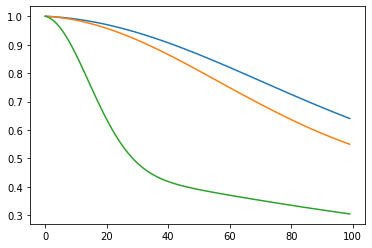

In [5]:
A = sklearn.datasets.make_low_rank_matrix(100,100,100)
U, sFR, VT = np.linalg.svd(A,full_matrices=0)
A = sklearn.datasets.make_low_rank_matrix(100,100,80)
U, sHR, VT = np.linalg.svd(A,full_matrices=0)
A = sklearn.datasets.make_low_rank_matrix(100,100,20)
U, sLR, VT = np.linalg.svd(A,full_matrices=0)
plt.plot(range(len(sFR)),sFR)
plt.plot(range(len(sHR)),sHR)
plt.plot(range(len(sLR)),sLR)

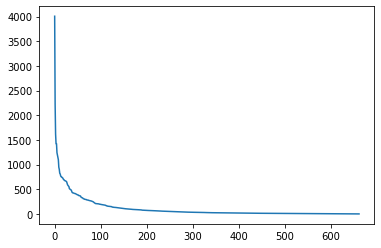

In [6]:
import scipy as sc

sparse_data = sc.io.mmread('662_bus.mtx')
Z = sparse_data.toarray()

U, s, VT = np.linalg.svd(Z,full_matrices=0)
plt.plot(range(len(s)),s)

### -------- High rank --------
This part focuses on the use of rsvd in the case of high rank matrices.
The matrix used as an example here is of shape (1000,1000), and of effective rank 800.

#### Fixed-rank
This comparison details the errors discrepancies between the fixed-rank, and factorized fixed-rank versions.

In [7]:
n = 995
A = sklearn.datasets.make_low_rank_matrix(1000,1000,800)
erreurs, erreurs2 = [], []
for index in range(10,n,10):
    rsvd = RSVD(A, None, rank=index)
    rsvd2 = RSVD(A, None, rank=index)
    rsvd.compute_orthogonal_base_Q_rank_with_factorisation(0)
    rsvd2.compute_orthogonal_base_Q_rank(0)
    U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
    U_tilde2, s_tilde2, VT_tilde2 = rsvd2.compute_svd_truncation()
    S_tilde = np.diag(s_tilde)
    S_tilde2 = np.diag(s_tilde2)
    A_tilde = U_tilde @ S_tilde @ VT_tilde
    A_tilde2 = U_tilde2 @ S_tilde2 @ VT_tilde2
    erreurs.append(np.linalg.norm(A-A_tilde)/np.linalg.norm(A))
    erreurs2.append(np.linalg.norm(A-A_tilde2)/np.linalg.norm(A))

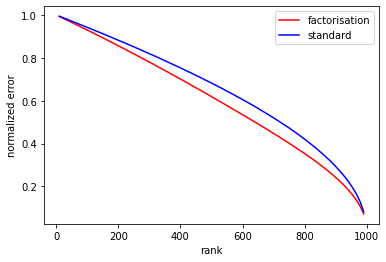

In [8]:
plt.plot(range(10,n,10),erreurs,'r',label='factorisation')
plt.plot(range(10,n,10),erreurs2,'b',label='standard')
plt.xlabel('rank')
plt.ylabel('normalized error')
plt.legend()
plt.show()

As we can see first here, the error decreases as the rank increases.

Furthermore, with the factorisation, the error is reduced, and the resulting curve is slightly smoother.

Factorisation is recommended is this case, because of the slow decay of the singular values, as was previously exposed.

The factorisation modifies the singular values for a faster decay.

In [9]:
A = sklearn.datasets.make_low_rank_matrix(100,100,80)
erreurs, erreurs2 = [], []
for index in range(95):
    rsvd = RSVD(A, None, rank=index)
    rsvd2 = RSVD(A, None, rank=index)
    rsvd.compute_orthogonal_base_Q_rank_with_factorisation(0)
    rsvd2.compute_orthogonal_base_Q_rank_with_factorisation(1)
    U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
    U_tilde2, s_tilde2, VT_tilde2 = rsvd2.compute_svd_truncation()
    S_tilde = np.diag(s_tilde)
    S_tilde2 = np.diag(s_tilde2)
    A_tilde = U_tilde @ S_tilde @ VT_tilde
    A_tilde2 = U_tilde2 @ S_tilde2 @ VT_tilde2
    erreurs.append(np.linalg.norm(A-A_tilde)/np.linalg.norm(A))
    erreurs2.append(np.linalg.norm(A-A_tilde2)/np.linalg.norm(A))

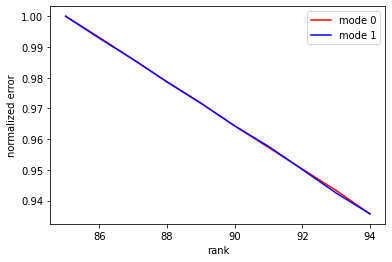

In [10]:
plt.plot(range(85,95),erreurs[:10],'r',label='mode 0')
plt.plot(range(85,95),erreurs2[:10],'b',label='mode 1')
plt.xlabel('rank')
plt.ylabel('normalized error')
plt.legend()
plt.show()

The difference between the methods of genereration of the test matrix is not significant.

#### Comparison between truncated matrix A and randomized fixed-rank svd (precision)

In [11]:
A = sklearn.datasets.make_low_rank_matrix(100,100,80)
U, s, VT = np.linalg.svd(A,full_matrices=0)
S = np.diag(s[:80])
A_80_svd = U[:,:80] @ S @ VT[:80,:]
rsvd = RSVD(A, None, rank=80)
rsvd.compute_orthogonal_base_Q_rank(0)
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
S_tilde = np.diag(s_tilde)
A_tilde = U_tilde @ S_tilde @ VT_tilde
print(np.linalg.norm(A_80_svd-A)/np.linalg.norm(A))
print(np.linalg.norm(A_tilde-A)/np.linalg.norm(A))

0.3256866580078294
0.3969401454350575


Our approach is close to the norm of the truncated version of A, which is the best low-rank representation of matrix A.

As we will see below, this method has the advantages of time performance and memory efficiency.

#### Comparison between normal and randomized fixed-rank svd (time), normal and randomized fixed precision svd (time)

In [12]:
A = sklearn.datasets.make_low_rank_matrix(2000,2000,1600)

In [13]:
%%timeit
U, s, VT = np.linalg.svd(A,full_matrices=0)

2.06 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
rsvd = RSVD(A, None, rank=80)
rsvd.compute_orthogonal_base_Q_rank(0)
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()

51 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
rsvd = RSVD(A, 10)
rsvd.compute_orthogonal_base_Q_epsilon_with_factorisation()
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()

16.6 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we can see the small loss in precision is here justified by an important gain in speed, especially for the fixed rank case.

Normally for the fixed precision case, the extra computational cost would be relevant, but as we had to reimplement it with an explicit python loop instead of a c++ loop (numpy vectorized).

### -------- Low rank --------
This part focuses on the use of rsvd in the case of low rank matrices.
The matrix used as an example here is of shape (1000,1000), and of effective rank 200.

#### Fixed rank
This comparison details the errors discrepancies between the fixed-rank, and factorized fixed-rank versions.

In [16]:
n = 995
A = sklearn.datasets.make_low_rank_matrix(1000,1000,200)
erreurs, erreurs2 = [], []
for index in range(10,n,10):
    rsvd = RSVD(A, None, rank=index)
    rsvd2 = RSVD(A, None, rank=index)
    rsvd.compute_orthogonal_base_Q_rank_with_factorisation(0)
    rsvd2.compute_orthogonal_base_Q_rank(0)
    U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
    U_tilde2, s_tilde2, VT_tilde2 = rsvd2.compute_svd_truncation()
    S_tilde = np.diag(s_tilde)
    S_tilde2 = np.diag(s_tilde2)
    A_tilde = U_tilde @ S_tilde @ VT_tilde
    A_tilde2 = U_tilde2 @ S_tilde2 @ VT_tilde2
    erreurs.append(np.linalg.norm(A-A_tilde)/np.linalg.norm(A))
    erreurs2.append(np.linalg.norm(A-A_tilde2)/np.linalg.norm(A))

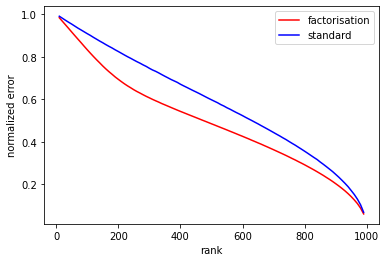

In [17]:
plt.plot(range(10,n,10),erreurs,'r',label='factorisation')
plt.plot(range(10,n,10),erreurs2,'b',label='standard')
plt.xlabel('rank')
plt.ylabel('normalized error')
plt.legend()
plt.show()

As we can see first here, the error decreases as the rank increases.

Furthermore, with the factorisation, the error is reduced, and the resulting curve is slightly smoother.

Factorisation is recommended is this case, because of the slow decay of the singular values.

The factorisation modifies the singular values for a faster decay.

In [18]:
A = sklearn.datasets.make_low_rank_matrix(100,100,20)
erreurs, erreurs2 = [], []
for index in range(95):
    rsvd = RSVD(A, None, rank=index)
    rsvd2 = RSVD(A, None, rank=index)
    rsvd.compute_orthogonal_base_Q_rank_with_factorisation(0)
    rsvd2.compute_orthogonal_base_Q_rank_with_factorisation(1)
    U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
    U_tilde2, s_tilde2, VT_tilde2 = rsvd2.compute_svd_truncation()
    S_tilde = np.diag(s_tilde)
    S_tilde2 = np.diag(s_tilde2)
    A_tilde = U_tilde @ S_tilde @ VT_tilde
    A_tilde2 = U_tilde2 @ S_tilde2 @ VT_tilde2
    erreurs.append(np.linalg.norm(A-A_tilde)/np.linalg.norm(A))
    erreurs2.append(np.linalg.norm(A-A_tilde2)/np.linalg.norm(A))

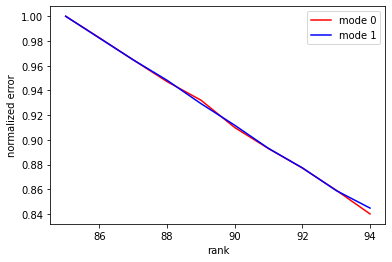

In [19]:
plt.plot(range(85,95),erreurs[:10],'r',label='mode 0')
plt.plot(range(85,95),erreurs2[:10],'b',label='mode 1')
plt.xlabel('rank')
plt.ylabel('normalized error')
plt.legend()
plt.show()

#### Fixed-precision

In [20]:
A = sklearn.datasets.make_low_rank_matrix(100,100,20)
grid = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
rankA_tilde, rankA_tilde2 = [], []
for index in grid:
    rsvd = RSVD(A, index)
    rsvd2 = RSVD(A, index)
    rsvd.compute_orthogonal_base_Q_epsilon_with_factorisation()
    rsvd2.compute_orthogonal_base_Q_epsilon()
    U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
    U_tilde2, s_tilde2, VT_tilde2 = rsvd2.compute_svd_truncation()
    S_tilde = np.diag(s_tilde)
    S_tilde2 = np.diag(s_tilde2)
    A_tilde = U_tilde @ S_tilde @ VT_tilde
    A_tilde2 = U_tilde2 @ S_tilde2 @ VT_tilde2
    rankA_tilde.append(rsvd.Q.shape[1])
    rankA_tilde2.append(rsvd.Q.shape[1])

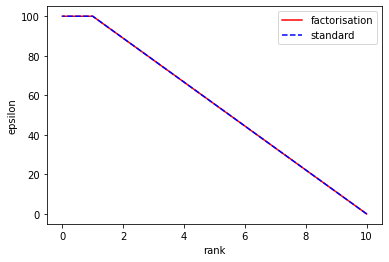

In [21]:
plt.plot(grid,rankA_tilde,'r',label='factorisation')
plt.plot(grid,rankA_tilde2,'b',linestyle='dashed',label='standard')
plt.xlabel('rank')
plt.ylabel('epsilon')
plt.legend()
plt.show()

As the effective rank of the matrix decreases, the needed numbers of columns of the matrix decreases too.

#### Comparison between truncated matrix A and randomized fixed-rank svd (precision)

In [22]:
A = sklearn.datasets.make_low_rank_matrix(100,100,20)
U, s, VT = np.linalg.svd(A,full_matrices=0)
S = np.diag(s[:80])
A_80_svd = U[:,:80] @ S @ VT[:80,:]
rsvd = RSVD(A, None, rank=80)
rsvd.compute_orthogonal_base_Q_rank(0)
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()
S_tilde = np.diag(s_tilde)
A_tilde = U_tilde @ S_tilde @ VT_tilde
print(np.linalg.norm(A_80_svd-A)/np.linalg.norm(A))
print(np.linalg.norm(A_tilde-A)/np.linalg.norm(A))

0.27144245246399307
0.33542779801413936


Our approach is even closer to the result achieved in the high rank scenario, but the use of the truncated matrix is still better in precision.

As we will see below, this method has the advantages of time performance and memory efficiency.

As we commented above, the singular values in a high rank matrix decays slowly, so the factorisation is more important in this case, while in the low rank matrix the singular values decay much faster.

#### Comparison between normal and randomized fixed-rank svd (time), normal and randomized fixed precision svd (time)

In [23]:
A = sklearn.datasets.make_low_rank_matrix(2000,2000,400)

In [24]:
%%timeit
U, s, VT = np.linalg.svd(A,full_matrices=0)

1.55 s ± 82.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
rsvd = RSVD(A, None, rank=80)
rsvd.compute_orthogonal_base_Q_rank(0)
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()

54.4 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit
rsvd = RSVD(A, 10)
rsvd.compute_orthogonal_base_Q_epsilon_with_factorisation()
U_tilde, s_tilde, VT_tilde = rsvd.compute_svd_truncation()

16.7 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Here we have results similar to the high rank matrix case.